Our final model, although the one in cli.py has some improvements and better code, this one is just a demonstration.

In [1]:
import sys

sys.path.append("..")

import time
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from utils import config

In [2]:
%%time
# Load data from the dataset
separator = "','"
sql_read_query = f""" SELECT
                t2.CountryCode as Country,
                t1.Year,
                t3.IndicatorName,
                t1.Value                
                FROM CountryIndicators t1
                LEFT JOIN
                (SELECT ShortName as Country, CountryCode from Countries) t2
                ON t1.CountryCode = t2.CountryCode
                LEFT JOIN
                (SELECT IndicatorCode, IndicatorName from Indicators)t3
                ON t1.IndicatorCode = t3.IndicatorCode
                WHERE t3.IndicatorName in ('{separator.join(config.INDICATORS)}');"""

with sqlite3.connect(config.DATABASE_PATH) as conn:
    country_indicators_df = pd.read_sql(sql_read_query,conn)

CPU times: user 5.97 s, sys: 64.7 ms, total: 6.03 s
Wall time: 6.03 s


In [3]:
# Features List
target = config.TARGET
gdp = config.GDP_GROWTH
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])

features = pivoted_df.columns.tolist()
print("Features Len:",len(features))
print(features)

Features Len: 49
['Adjusted net national income (annual % growth)', 'Adjusted net national income per capita (current US$)', 'Adjusted savings: education expenditure (% of GNI)', 'Adjusted savings: net national savings (% of GNI)', 'Agriculture, value added (annual % growth)', 'CO2 emissions (kt)', 'Crop production index (2004-2006 = 100)', 'Death rate, crude (per 1,000 people)', 'Export value index (2000 = 100)', 'Export volume index (2000 = 100)', 'Exports of goods and services (annual % growth)', 'External balance on goods and services (% of GDP)', 'External balance on goods and services (current LCU)', 'Food production index (2004-2006 = 100)', 'Foreign direct investment, net inflows (% of GDP)', 'Foreign direct investment, net inflows (BoP, current US$)', 'GDP deflator (base year varies by country)', 'GDP growth (annual %)', 'GDP per capita (current US$)', 'GDP per capita growth (annual %)', 'GDP per unit of energy use (PPP $ per kg of oil equivalent)', 'GNI growth (annual %)', 'G

Commented code for previous year -> flag in cli.py, although we didn't see much of a difference

We only use dropna for the rows where our target is missing, otherwise XGBoost can deal with them

In [4]:
# for indicator in features:
#    indicator_1 = country_indicators_df.loc[country_indicators_df["IndicatorName"] == indicator].copy()
#    indicator_1["Year"] += 1
#    indicator_1.set_index(["Country", "Year"], inplace=True)
#    indicator_1.rename(columns={"Value": "Previous "+indicator}, inplace=True)
#    indicator_1.drop(columns=["IndicatorName"], inplace=True)
#    pivoted_df = pivoted_df.join(indicator_1)
# features = pivoted_df.columns.tolist()

target_df = country_indicators_df.loc[country_indicators_df["IndicatorName"] == gdp].copy()
target_df["Year"] -= 1
target_df.set_index(["Country", "Year"], inplace=True)
target_df.rename(columns={"Value": "Next GDP Growth"}, inplace=True)
target_df.drop(columns=["IndicatorName"], inplace=True)
df = pivoted_df.join(target_df)

df = df.dropna(subset=[target])  # Drop row if target is not present
df.shape

(9057, 50)

In [5]:
# Test-train split
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6339, 49)
X_test shape: (2718, 49)
y_train shape: (6339,)
y_test shape: (2718,)


Initialize model, with parameters in config file

In [6]:
xg_reg = xgb.XGBRegressor(**config.XG_PARAMS)

In [7]:
# Train and test
t0 = time.time()
xg_reg.fit(X_train, y_train)
print(f"Elapsed time training: {time.time() - t0} seconds")
t0 = time.time()
xg_reg_y_pred = xg_reg.predict(X_test)
print(f"Elapsed time predicting: {time.time() - t0} seconds")

results_df = X_test
results_df = results_df.drop(columns=features)
results_df["y_real"] = y_test
results_df["y_pred"] = xg_reg_y_pred
results_df["err"] = np.absolute(results_df["y_real"] - results_df["y_pred"])
results_df["%_err"] = ((results_df["err"]) /(np.absolute (results_df["y_real"]))* 100)

print(f"RMSE: {mean_squared_error(y_test, xg_reg_y_pred)**0.5}")
print(f"R^2: {r2_score(y_test, xg_reg_y_pred)}")

results_df 

Elapsed time training: 1.4689090251922607 seconds
Elapsed time predicting: 0.0053484439849853516 seconds
RMSE: 5.161150756365517
R^2: 0.2264449591406571


,,y_real,y_pred,err,%_err
Country,Year,,,,
ALB,1982,1.104938,3.051847,1.946909,176.200699
GHA,1983,8.647569,1.468752,7.178817,83.015434
HTI,2007,0.843944,3.848810,3.004866,356.050247
COG,1977,6.359747,-1.282841,7.642588,120.171263
MNA,1996,3.052934,4.581749,1.528816,50.076934
...,...,...,...,...,...
CRI,2008,-1.015719,2.262132,3.277851,322.712384
MIC,1986,4.469074,3.657300,0.811775,18.164268
MEX,2004,3.032574,4.064568,1.031994,34.030300


Plots are created from the module plots.py, and exported to the models folder

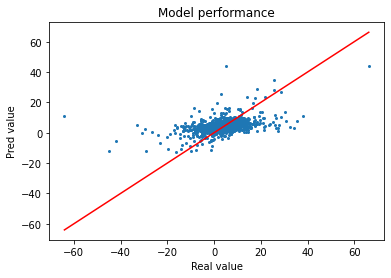

In [8]:
#Predicted Value Plot

fig, ax = plt.subplots()
plot_range = [results_df["y_real"].min(), results_df["y_real"].max()] 
ax.set_title("Model performance")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")

ax.scatter(results_df["y_real"], results_df["y_pred"], s=4)
ax.plot(plot_range, plot_range, c="red")
plt.show()

Here, the year column is hardcoded, while in cli.py it is the last one present in the database, or the one given as an input

In [9]:
# Prediction for 2011, using the last indicators info
# To do: write the info into data-base
pivoted_df = country_indicators_df.pivot(values='Value', index=['Country', 'Year'], columns=['IndicatorName'])
country_list = pivoted_df.index.unique('Country')

#Dataframe with all the countries
predictions = pd.DataFrame(country_list) 

#for country in country_list: 
predictions["Year"] = 2011
predictions["Value"] = xg_reg.predict(pivoted_df.filter(like = f"{2010}", axis=0))
predictions.rename(columns={'Country': 'CountryCode'}, inplace=True)
predictions

,CountryCode,Year,Value
0,ABW,2011,1.685222
1,ADO,2011,-1.812026
2,AFG,2011,5.701902
3,AGO,2011,2.393778
4,ALB,2011,4.127574
...,...,...,...
242,YEM,2011,3.986965
243,ZAF,2011,2.822271
244,ZAR,2011,7.072944
245,ZMB,2011,8.766299


In [10]:
with sqlite3.connect(config.DATABASE_PATH) as conn:
    predictions.to_sql('EstimatedGDPGrowth', conn, if_exists='replace', index = False)

In [11]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xg_reg)

In [12]:
%%time
shap_values = explainer.shap_values(X_test)

CPU times: user 4.85 s, sys: 0 ns, total: 4.85 s
Wall time: 849 ms


We can see that the GDP growth is the most important indicator to predict the next year GDP growth, no surprise here

The second one is interresting though, the expense in education seems to be a good predictor of GDP growth

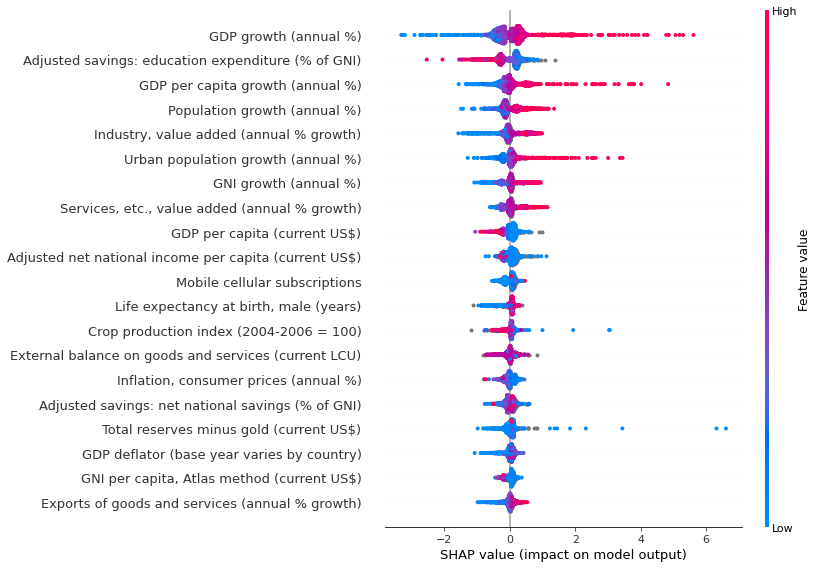

In [13]:
shap.summary_plot(shap_values, X_test,feature_names=features)

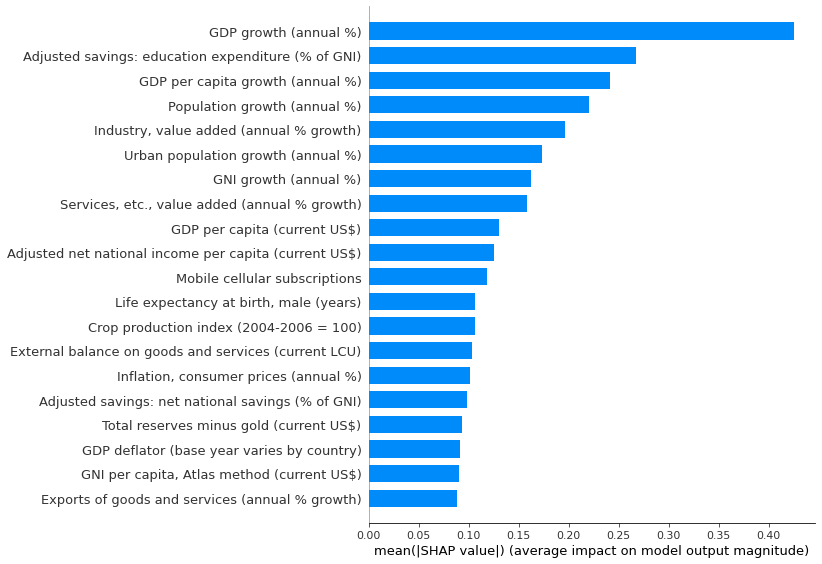

In [14]:
shap.summary_plot(shap_values, X_test, plot_type="bar",feature_names=features)

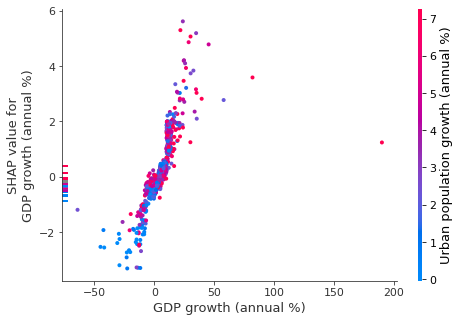

In [18]:
shap.dependence_plot("GDP growth (annual %)", shap_values, X_test)

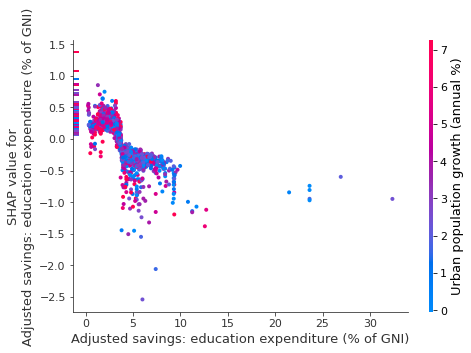

In [21]:
shap.dependence_plot("Adjusted savings: education expenditure (% of GNI)", shap_values, X_test)